# Functions

In [1]:
import numpy as np
import pandas as pd
import uuid
import matplotlib.pyplot as plt
from scipy.stats import pareto, gompertz, norm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


# Basic calculation functions
############################################################################################################################
def process_dataframe(df, num_percentiles=10, percentile_col='prod_perc'):
    """
    Process a DataFrame by computing production percentages, cumulative sums, and logarithmic transformations.
    Additionally, it normalizes values and applies percentile binning.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing production data.
    - num_percentiles (int): Number of percentiles for binning.
    - percentile_col (str): Column name to use for percentile binning.

    Returns:
    - pd.DataFrame: Processed DataFrame with computed features.
    """
    # Filter for non-zero 'prod' values
    df = df[df["prod"] > 0].copy()
    # Calculate percentage representation of each CNAE
    length_nonzero = len(df)
    df["cnae_perc"] = 100 / length_nonzero
    # Compute production percentages
    df["prod_perc"] = df["prod"] / df["prod"].sum() * 100
    # Sort by production percentage in ascending order
    df = df.sort_values(by="prod_perc", ascending=True).reset_index(drop=True)
    # Compute cumulative sum of CNAE percentage
    df["cnae_perc_cumsum"] = df["cnae_perc"].cumsum()
    # Compute logarithmic transformations
    df["log_prod_perc"] = np.log(df["prod_perc"])
    df["log_cnae_perc_cumsum"] = np.log(df["cnae_perc_cumsum"])
    df["log_log_cnae_perc_cumsum"] = np.log(1 + np.abs(df["log_cnae_perc_cumsum"].min()) + df["log_cnae_perc_cumsum"])
    # Normalize logarithmic cumulative sum
    log_min, log_max = df["log_cnae_perc_cumsum"].min(), df["log_cnae_perc_cumsum"].max()
    df["log_log_cnae_perc_cumsum_norm"] = (df["log_cnae_perc_cumsum"] - log_min) * 100 / (log_max - log_min)
    # Normalize doubly logged cumulative sum
    log_log_min, log_log_max = df["log_log_cnae_perc_cumsum"].min(), df["log_log_cnae_perc_cumsum"].max()
    df["log_log_cnae_perc_cumsum_norm"] = (df["log_log_cnae_perc_cumsum"] - log_log_min) * 100 / (log_log_max - log_log_min)
    # Apply percentile binning
    if percentile_col in df.columns:
        df[f"{percentile_col}_percentile"], bins = pd.qcut(df[percentile_col], 
                                                            q=num_percentiles, 
                                                            labels=[f"P{i+1}" for i in range(num_percentiles)],
                                                            retbins=True)
        # Add lower and upper bounds for each percentile bin
        lower_bounds = bins[:-1]
        upper_bounds = bins[1:]
        percentile_to_bounds = {f"P{i+1}": (lower_bounds[i], upper_bounds[i]) for i in range(num_percentiles)}
        df["lower_bound_bin_interval"] = df[f"{percentile_col}_percentile"].map(lambda p: percentile_to_bounds[p][0])
        df["upper_bound_bin_interval"] = df[f"{percentile_col}_percentile"].map(lambda p: percentile_to_bounds[p][1])
        df[f"{percentile_col}_bin_interval"] = df[f"{percentile_col}_percentile"].map(
            lambda p: f"[{percentile_to_bounds[p][0]:.2f}, {percentile_to_bounds[p][1]:.2f}]"
        )
    else:
        raise ValueError(f"Column '{percentile_col}' not found in the DataFrame.")
    return df


def logarith_binning(df, prod_col='prod', cnae_perc_col='cnae_perc', growth=1.1):
    """
    Perform logarithmic binning of production values to group similar values together.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing production data.
    - prod_col (str): Column containing production values.
    - cnae_perc_col (str): Column containing CNAE percentages.
    - growth (float): Growth rate for determining bin intervals.

    Returns:
    - pd.DataFrame: DataFrame with added binning columns.
    """
    # Ensure the DataFrame is sorted by production values
    df.sort_values(by=prod_col, inplace=True)
    # Initialize binning lists
    prod_perc_bin = [df[prod_col].iloc[0]]  # Start with the smallest production value
    cnae_perc_bin = [] 
    # Generate bin edges based on growth rate
    while prod_perc_bin[-1] < df[prod_col].sum():
        next_bin = growth * prod_perc_bin[-1]
        prod_perc_bin.append(next_bin)
        cnae_perc_bin.append(df.loc[df[prod_col] > next_bin, cnae_perc_col].sum())
    # Remove empty bins
    cnae_perc_bin = [x for x in cnae_perc_bin if x > 0]
    prod_perc_bin = prod_perc_bin[:len(cnae_perc_bin)]
    # Align bin sizes with DataFrame length
    bin_length = len(prod_perc_bin)
    df['prod_perc_bin'] = prod_perc_bin + [prod_perc_bin[-1]] * (len(df) - bin_length)
    df['cnae_perc_bin'] = cnae_perc_bin + [cnae_perc_bin[-1]] * (len(df) - len(cnae_perc_bin))
    return df


def synthetic_df(size=1000, seed=42):
    """
    Generate a final dataset by stacking four different probability distributions:
    Pareto (Power Law), Gompertz, Lognormal, and Normal. 
    Each distribution is assigned a label in the 'DistribType' column.

    Parameters:
    - size (int): Number of data points to generate per distribution.
    - seed (int): Random seed for reproducibility.

    Returns:
    - pd.DataFrame: Stacked DataFrame containing synthetic data from all four distributions.
    """
    np.random.seed(seed)

    # Generate data for each distribution
    data_pareto = pareto.rvs(b=2.5, scale=1.0, size=size)
    data_gompertz = gompertz.rvs(c=0.5, scale=1.0, size=size)
    data_lognormal = np.random.lognormal(mean=1, sigma=1, size=size)
    data_normal = norm.rvs(loc=0, scale=1, size=size)

    # Create DataFrames for each distribution with labels
    df_pareto = pd.DataFrame({'cnae': [str(uuid.uuid4()) for _ in range(size)], 
                              'prod': data_pareto, 'DistribType': 'pareto'})

    df_gompertz = pd.DataFrame({'cnae': [str(uuid.uuid4()) for _ in range(size)], 
                                'prod': data_gompertz, 'DistribType': 'gompertz'})

    df_lognormal = pd.DataFrame({'cnae': [str(uuid.uuid4()) for _ in range(size)], 
                                 'prod': data_lognormal, 'DistribType': 'lognormal'})

    df_normal = pd.DataFrame({'cnae': [str(uuid.uuid4()) for _ in range(size)], 
                              'prod': data_normal, 'DistribType': 'normal'})

    # Stack all DataFrames together
    final_df = pd.concat([df_pareto, df_gompertz, df_lognormal, df_normal], ignore_index=True)

    return final_df



# Pipeline data mining functions
############################################################################################################################
def process_distributions_log_binning(size=1000, seed=42, num_percentiles=10, percentile_col='prod_perc', growth=1.1):
    """
    Generate a synthetic dataset using different probability distributions, process each subset, 
    and then apply logarithmic binning.
    Iterates through the 'DistribType' column, processes each subset, applies logarithmic binning, 
    and concatenates the results.

    Parameters:
    - size (int): Number of data points to generate per distribution.
    - seed (int): Random seed for reproducibility.
    - num_percentiles (int): Number of percentiles for binning.
    - percentile_col (str): Column name to use for percentile binning.
    - growth (float): Growth rate for determining bin intervals.

    Returns:
    - pd.DataFrame: Processed and concatenated DataFrame for all distributions after processing 
                    and logarithmic binning.
    """
    # Generate the full dataset with all distributions
    df_full = synthetic_df(size=size, seed=seed)
    # Initialize an empty DataFrame to store processed results
    df_processed = pd.DataFrame()
    # Iterate through each unique distribution type and process separately
    for distrib in df_full['DistribType'].unique():
        df_subset = df_full[df_full['DistribType'] == distrib].copy()
        # First, process the dataframe to compute necessary columns
        df_subset = process_dataframe(df_subset, num_percentiles=num_percentiles, percentile_col=percentile_col)
        # Then apply logarithmic binning
        df_subset = logarith_binning(df_subset, prod_col='prod', cnae_perc_col='cnae_perc', growth=growth)
        #
        df_processed = pd.concat([df_processed, df_subset], ignore_index=True)
    return df_processed


# Pipeline graphics functions
############################################################################################################################
def plot_distributions_grid(df):
    """
    Plot subplots of distributions iterating through the DistribType column,
    using a 2x2 grid layout for better visualization.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing production data and distribution types.

    Returns:
    - None: Displays the histograms.
    """
    unique_distributions = df['DistribType'].unique()
    num_distributions = len(unique_distributions)

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    for ax, distrib in zip(axes, unique_distributions):
        subset = df[df['DistribType'] == distrib]
        ax.hist(subset['prod'], bins=50, density=True, alpha=0.75, edgecolor='black', color='royalblue')
        ax.set_ylabel('Density', fontsize=12)
        ax.set_xlabel('Production Value (prod)', fontsize=12)
        ax.set_title(f'{distrib.capitalize()} Distribution', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)
        #ax.set_yscale('log')  # Log scale for better visualization

    # Remove any empty subplots (if needed)
    for i in range(num_distributions, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    
    
def plot_cumulative_id_count_grid(df):
    """
    Plot subplots of Cumulative ID Count vs. -log(Production Values) iterating 
    through the DistribType column, using a 2x2 grid layout.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing production data and distribution types.

    Returns:
    - None: Displays the cumulative plots.
    """
    unique_distributions = df['DistribType'].unique()
    num_distributions = len(unique_distributions)

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    for ax, distrib in zip(axes, unique_distributions):
        subset = df[df['DistribType'] == distrib]
        ax.plot(-np.log(subset['prod']), subset['cnae_perc_cumsum'], marker='o', linestyle='-', alpha=0.7, color='royalblue')
        ax.set_xlabel('-log(Production Value)', fontsize=12)
        ax.set_ylabel('Cumulative ID Count', fontsize=12)
        ax.set_title(f'Cumulative ID Count - {distrib.capitalize()}', fontsize=14, fontweight='bold')
        ax.grid(True, linestyle='--', alpha=0.6)

    # Remove any empty subplots (if needed)
    for i in range(num_distributions, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    

def plot_log_log_regression_grid(df):
    """
    Perform a log-log regression on the relationship between production values 
    and cumulative CNAE percentage bins, then plot the results in a 2x2 grid layout.

    Parameters:
    - df (pd.DataFrame): Input DataFrame containing production data and CNAE percentage bins.

    Returns:
    - None: Displays the log-log regression plots.
    """
    unique_distributions = df['DistribType'].unique()
    num_distributions = len(unique_distributions)

    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
    axes = axes.flatten()  # Flatten axes array for easier iteration

    for ax, distrib in zip(axes, unique_distributions):
        subset = df[df['DistribType'] == distrib]

        # Group the DataFrame by 'cnae_perc_bin' and compute mean production percentage
        tb = subset.groupby(['cnae_perc_bin']).agg(prod=('prod_perc_bin', 'mean')).reset_index()

        # Convert to numpy arrays for regression
        x = np.array(tb['prod']).reshape(-1, 1)
        y = np.array(tb['cnae_perc_bin']).reshape(-1, 1)

        # Apply log transformation
        x = np.log(x)
        y = np.log(y)

        # Perform linear regression
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)

        # Calculate R-squared value
        r_squared = r2_score(y, y_pred)

        # Plot log-log regression
        ax.plot(x, y, marker='o', linestyle='-', alpha=0.7, label='Data')
        ax.plot(x, y_pred, label=f'Linear Fit (R²={r_squared:.4f})', color='red', linewidth=2)

        ax.set_xlabel('Log(Production Value)', fontsize=10)
        ax.set_ylabel('Log(Cumulative CNAE Count)', fontsize=10)
        ax.set_title(f'Log-Log Regression - {distrib.capitalize()}', fontsize=12, fontweight='bold')
        ax.legend()
        ax.grid(True, which="both", linestyle="--", linewidth=0.5)

    # Remove any empty subplots (if needed)
    for i in range(num_distributions, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()

# Introduction

In many real-world systems, the distribution of values is far from uniform or normal. Instead, they often follow heavy-tailed distributions, where a small number of extreme values dominate the overall sum. Understanding these distributions is essential in fields such as economics, physics, network science, and risk management, where rare but significant events can have outsized impacts.

This project explores different probability distributions—Pareto, Gompertz, Lognormal, and Normal—to analyze their statistical properties and how they behave under logarithmic transformations. Using a synthetic dataset, I systematically compare these distributions through histograms, cumulative plots, and log-log regressions to identify power-law behavior, tail characteristics, and deviations from linearity.

By applying logarithmic binning and regression models, I examine how well each distribution aligns with a power-law trend, a fundamental property in many natural and economic systems. The results provide insight into when power-law approximations are valid, when alternative models are necessary, and how different probability distributions shape real-world data analysis.

This approach serves as both a theoretical exploration and a practical framework for recognizing and interpreting distributional properties in data-driven applications.

# **Introduction to the Distributions**  

## **Pareto Distribution**  
The **Pareto distribution** is a classic example of a **power-law** distribution, where a small number of high values contribute disproportionately to the total sum. It is often used to model **wealth distribution, city sizes, and internet traffic**, where a few entities hold the majority of the resources or influence. Mathematically, it follows the form:  

$$
P(X > x) \propto x^{-\alpha}
$$

where \(\alpha\) is the **shape parameter** that controls how heavy the tail is. The heavier the tail, the more extreme values dominate the dataset. This distribution is crucial in fields where **inequality and concentration of resources** play a major role.  

## **Gompertz Distribution**  
The **Gompertz distribution** is widely used in **biological and survival analysis**, where growth slows down over time. It is particularly effective in modeling **lifespan, tumor growth, and population dynamics**, as it captures a system where the probability of extreme values decreases more sharply than in Pareto but remains right-skewed. Its probability density function (PDF) is given by:

$$
f(x) = c e^{-b x} e^{-c e^{-b x}}
$$

where \(b\) and \(c\) are shape parameters that control the decay rate. Unlike Pareto, Gompertz distributions do not follow a strict power-law but instead **exhibit exponential-like decay** at larger values.  

## **Lognormal Distribution**  
The **Lognormal distribution** is commonly used in cases where values **grow multiplicatively** rather than additively. This makes it highly applicable to **stock prices, income distributions, and physical processes** such as particle sizes. A variable \(X\) follows a Lognormal distribution if:

$$
\log(X) \sim \mathcal{N}(\mu, \sigma^2)
$$

meaning that its logarithm is normally distributed. The key characteristic of a lognormal distribution is its **long tail**, similar to Pareto, but with a smoother transition between small and large values. This makes it an intermediate model between heavy-tailed and light-tailed distributions.  

## **Normal Distribution**  
The **Normal distribution**, or **Gaussian distribution**, is one of the most fundamental statistical models in nature. It follows the well-known **bell curve** and is described by the function:

$$
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x - \mu)^2}{2\sigma^2}}
$$

where \(\mu\) is the mean and \(\sigma\) is the standard deviation. Unlike the other distributions discussed, the Normal distribution is **symmetric**, meaning that extreme values are **rare and decrease rapidly** on both sides of the mean. It is widely used in **measurement errors, physical processes, and social sciences**, where values tend to cluster around an average rather than follow a power-law trend.  

Each of these distributions has distinct properties that shape how data behaves, especially in the presence of extreme values. Understanding these differences is critical for choosing the right statistical model in real-world applications.

# Pipeline

## Create synthetic data

In [2]:
# Generate the final dataset
df = synthetic_df(size=1000, seed=42)

# Run the function to generate and process the dataset with processing and logarithmic binning
df = process_distributions_log_binning(size=1000, seed=42, num_percentiles=10, percentile_col='prod_perc', growth=1.1)

## Distribution plots

The histograms display four different statistical distributions of production values (prod), each representing a unique probability model. The Pareto distribution (top left) follows a heavy-tailed pattern, where a large number of small values coexist with a few extreme outliers. This is a common feature in economics and natural systems, often used to model wealth distributions and market dynamics. The Gompertz distribution (top right) is also right-skewed, but its decline is more gradual, reflecting its typical application in modeling biological growth and survival processes.

The Lognormal distribution (bottom left) behaves similarly to the Pareto distribution but is less extreme, meaning that while larger values are possible, they are not as disproportionately dominant. Many natural and economic systems follow a lognormal pattern, such as stock prices, income levels, and internet traffic. Finally, the Normal distribution (bottom right) presents the familiar bell curve, where values cluster symmetrically around the mean. This is one of the most commonly observed distributions in nature and statistics, underpinning many fundamental models in physics, finance, and social sciences.

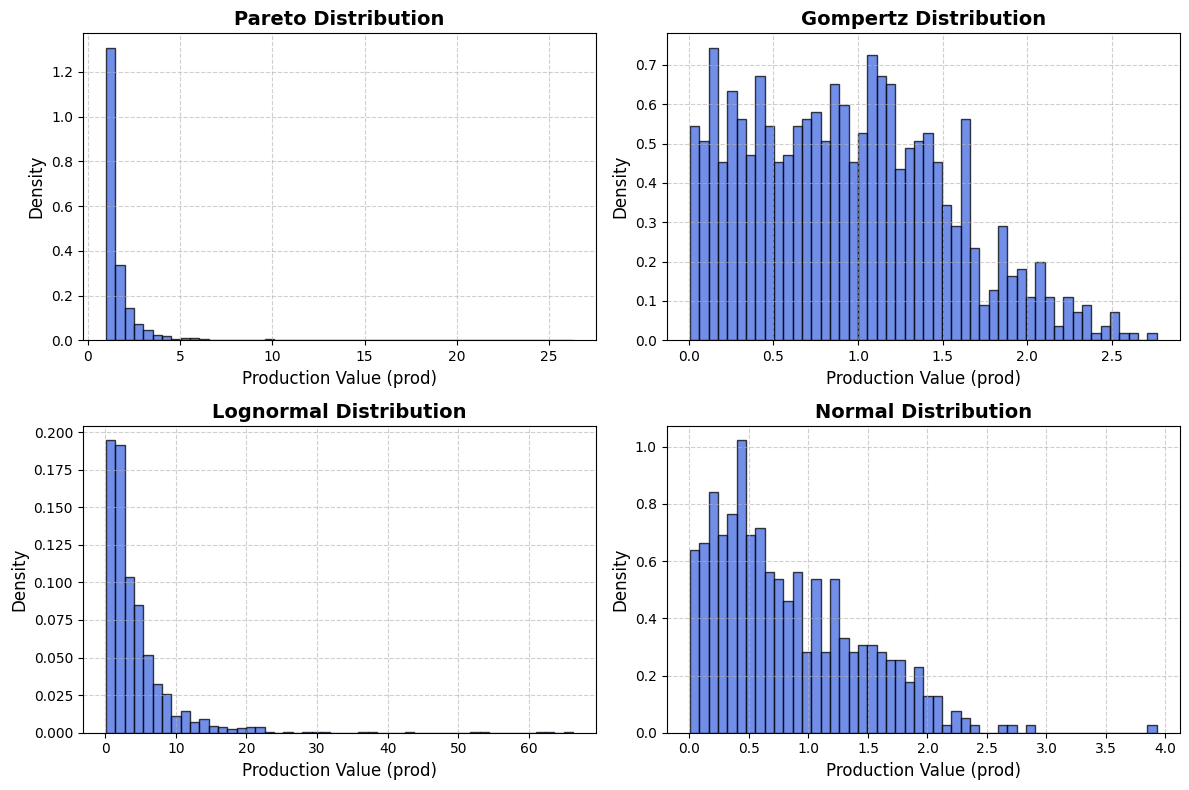

In [3]:
# Run the function to plot distributions in a 2x2 grid
plot_distributions_grid(df)

## Cumulative distributions

These plots show the cumulative ID count against the negative logarithm of production values for four different probability distributions: Pareto, Gompertz, Lognormal, and Normal. The cumulative count represents the proportion of observations with production values above a given threshold, helping to illustrate how each distribution behaves in terms of heavy-tailedness and decay.

In the Pareto distribution (top left), the curve remains relatively flat for a long portion before dropping sharply at the end. This behavior reflects the heavy-tailed nature of the Pareto distribution, where a few large values contribute significantly to the overall sum, while most values remain small. The decay is slow at first and then steepens as the highest values are included.

The Gompertz distribution (top right) shows a much smoother and more gradual decline, indicating a less extreme concentration of large values. Unlike Pareto, where a few high values dominate, Gompertz spreads values more evenly, though it still exhibits a right-skewed pattern.

The Lognormal distribution (bottom left) behaves similarly to Pareto but with a more continuous and smoother decay. It captures a middle ground between heavy-tailed and light-tailed behavior, where extreme values are still present but their influence is less pronounced compared to Pareto. This is often observed in natural processes involving multiplicative growth.

The Normal distribution (bottom right) follows a much more symmetrical and predictable decay pattern. The cumulative count decreases rapidly, reflecting the fact that extreme values are relatively rare in a normally distributed dataset. Unlike the other three distributions, which show clear skewness, the normal distribution maintains a balanced decline, indicating a much lower probability of extreme values.

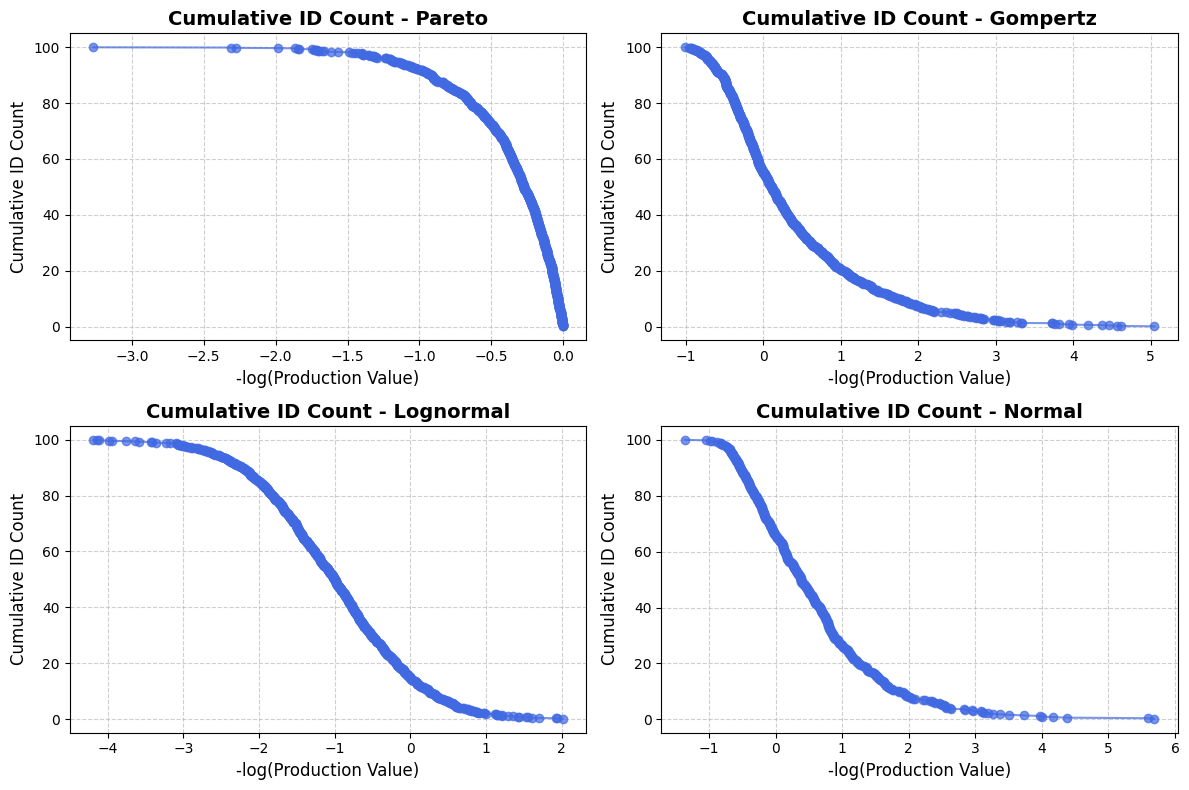

In [6]:
# Run the function to plot cumulative ID counts in a 2x2 grid
plot_cumulative_id_count_grid(df)

## Log-Log plots of Cumulative count vs Production

These plots show log-log regressions of the cumulative CNAE count against the production values for four different probability distributions: Pareto, Gompertz, Lognormal, and Normal. The blue dots represent the empirical data, while the red line represents the best linear fit on the log-log scale. The R² value in each plot indicates how well the linear model fits the data, with values closer to 1 signifying a strong linear relationship.

These results are based on a synthetic dataset generated using four different probability distributions: Pareto, Gompertz, Lognormal, and Normal. The data does not come from real-world observations but was instead created using well-known statistical models to illustrate their distinct behaviors. Since the dataset is artificial, the trends seen in the regressions strictly reflect the mathematical properties of each distribution rather than empirical processes. This approach allows for a controlled comparison of how different distributions behave in a log-log space, particularly in relation to power-law dynamics and heavy-tailed properties. The insights gained here are valuable for understanding which distributions are best suited for modeling real-world datasets, depending on whether extreme values and long tails are present.

The Pareto distribution (top left) exhibits a nearly perfect linear relationship in log-log space, as indicated by the high R² value (0.9669). This confirms the well-known property of Pareto distributions, which follow a power-law behavior, meaning that a small number of high-production values dominate the total sum.

The Gompertz distribution (top right) shows a much weaker linear fit, with an R² value of 0.4266. The data initially follows a roughly linear trend but then deviates significantly, curving downward. This suggests that Gompertz does not follow a strict power-law pattern, and its cumulative distribution exhibits a more exponential-like decay rather than a long-tailed distribution.

The Lognormal distribution (bottom left) demonstrates a partially linear trend, with an R² value of 0.8516, indicating that while lognormal distributions do have heavy tails, they do not adhere to a strict power-law as strongly as Pareto. The deviation from linearity in the lower values suggests a transition from a power-law tail to a different underlying distribution in the bulk of the data.

The Normal distribution (bottom right) has the weakest fit among all, with an R² value of 0.5316. The log-log plot of a normal distribution does not form a straight line, as it lacks the long-tail property of power-law distributions. Instead, the data initially remains flat and then drops off sharply, showing that extreme values in a normal distribution occur far less frequently than in Pareto or Lognormal distributions.

These results highlight the differences in tail behavior across distributions. The Pareto distribution follows a strict power law, the Lognormal distribution has a heavy but not perfectly power-law tail, while the Gompertz and Normal distributions do not exhibit strong power-law behavior. This distinction is crucial when modeling real-world data, especially in fields such as economics, network science, and risk analysis, where the choice of the distribution impacts predictions and interpretations.

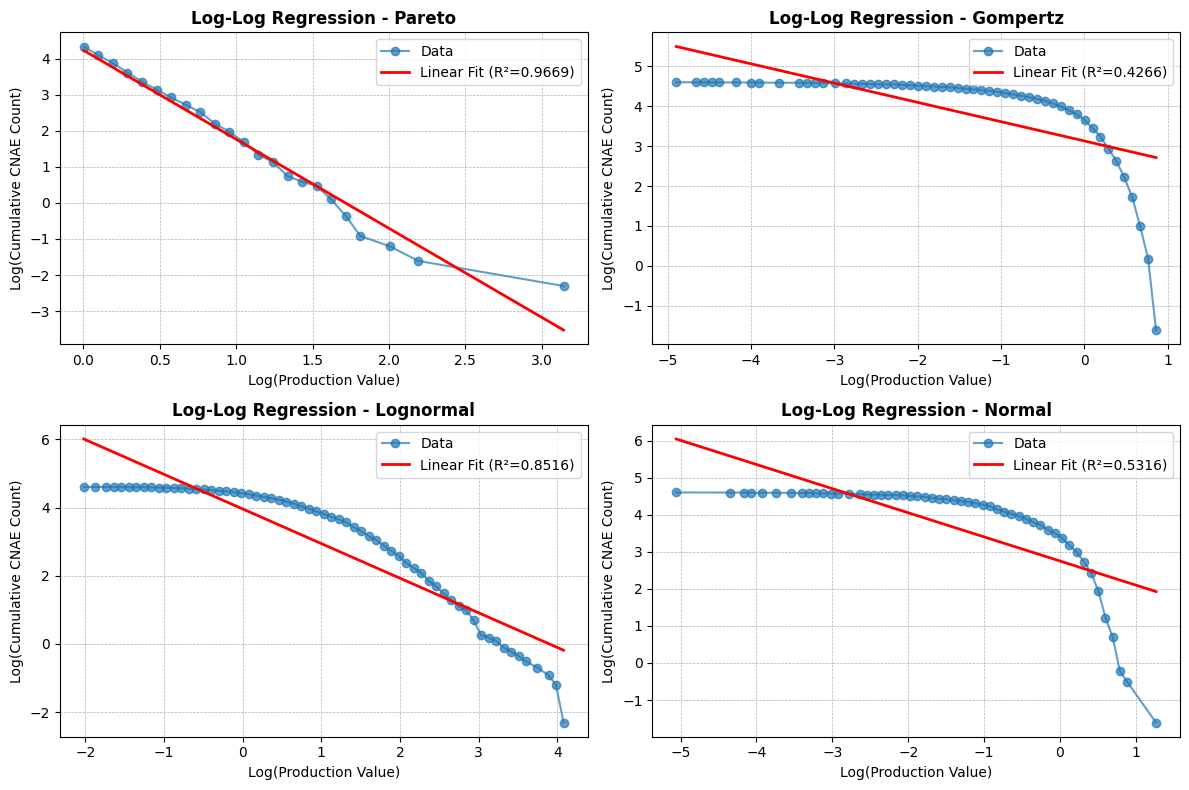

In [5]:
# Run the function to plot log-log regression in a 2x2 grid
plot_log_log_regression_grid(df)

# References

* https://www.kaggle.com/code/wuhong60909/nonlinear-regression-gompertz-model-2020-4-22
* https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gompertz.html#scipy.stats.gompertz
*